# Prerequisites

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

Using TensorFlow backend.


# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [3]:
n_diff = 1

for price in prices:
    price.scaled, price.scaler = data_transform(price, method='minmax')
    price.scaled_diff, price.correction = data_difference(price.scaled, n_diff)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)

# MLP

## Define functions
- mlp_fit
- mlp_forecast
- mlp_walk_forward

In [7]:
def mlp_fit(data, config, n_forecast=4):
    
    # unpack config
    n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
    
    # transform to kreas format
    x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast)
    x = x.to_numpy()
    y = y.to_numpy()
    
    # define model
    if n_layers!=1:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam')
        
    else:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam')
        
    # fit model
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

def mlp_forecast(model_fitted, data, date, n_forecast=4):
    """
    Forecast MLP model
    
    Args:
        model_fitted (model): Keras fitted model
        data (dataframe): number of lags to be used in the model
        date (date): first date to forecast
        n_fcast (int): number of steps to forecast
    
    Returns:
        
    """
    scaler = getattr(data, "scaler")
    correction = getattr(data, "correction")
    x_idx = data.scaled_diff.index.get_loc(date)
    n_input = model_fitted.input_shape[1]
    
    # find-input
    x = data.scaled_diff.iloc[x_idx-n_input:x_idx,]
    x_input = x.to_numpy().reshape(1,-1)
    
    # forecast
    yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
    K.clear_session()
    df = pd.DataFrame(yhat,
                      columns=["yhat_scaled"],
                      index=pd.date_range(date, periods=n_forecast, freq='MS')
                     )
    df['yhat_scaled'] = inverse_difference(df["yhat_scaled"], correction['y']).dropna()
    df['yhat'] = scaler.inverse_transform(df)
    
    return df['yhat']


def mlp_walk_forward(data, config, search_mode=False, n_forecast=4):
    
    train, test = select_traintest(data, search_mode)
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast+1
    yhat = np.empty((n_yhat, n_forecast))
    refit_rate = config[-1]
    history = train
    model_fitted = mlp_fit(history, config)
    
    for i in range(n_yhat):
        date = test.index[i]
        model_fitted = mlp_fit(history, config) if i%refit_rate==0 else model_fitted 
        yhat[i] = mlp_forecast(model_fitted, data, date, n_forecast=n_forecast)
        history = history.append(test.iloc[i])
        
    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)
    
    return yhat

## Generate Parameter Grid

In [8]:
n_input = [5, 11, 17]
n_layers = [1, 2]
n_nodes = [10, 20]
n_epochs = [5, 10, 20, 50]
n_batch = [64]
refit_rate = [np.inf]

mlp_configs = model_configs(n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
mlp_model = [mlp_fit, mlp_forecast, mlp_walk_forward, mlp_configs]

In [9]:
%%time
n_forecast = 4
npr.seed(1305)
for price in prices:
    price.mlp_grid_result, price.mlp_config = grid_search(price, mlp_model, n_forecast=n_forecast)
    price.mlp_yhat = forecast(price, mlp_model, price.mlp_config, n_forecast=n_forecast)

{'5-1-10-5-64-inf': {'rmse': 767.4719, 'mae': 454.3936, 'mape': 0.0352}}
{'5-1-10-10-64-inf': {'rmse': 791.9587, 'mae': 471.8157, 'mape': 0.0363}}
{'5-1-10-20-64-inf': {'rmse': 771.2034, 'mae': 462.0793, 'mape': 0.036}}
{'5-1-10-50-64-inf': {'rmse': 818.4997, 'mae': 478.0807, 'mape': 0.0371}}
{'5-1-20-5-64-inf': {'rmse': 740.3438, 'mae': 451.4552, 'mape': 0.0352}}
{'5-1-20-10-64-inf': {'rmse': 733.4914, 'mae': 436.7358, 'mape': 0.0341}}
{'5-1-20-20-64-inf': {'rmse': 716.7005, 'mae': 416.3995, 'mape': 0.0324}}
{'5-1-20-50-64-inf': {'rmse': 706.7055, 'mae': 415.9053, 'mape': 0.0325}}
{'5-2-10-5-64-inf': {'rmse': 699.2001, 'mae': 402.3149, 'mape': 0.0315}}
{'5-2-10-10-64-inf': {'rmse': 749.7633, 'mae': 429.6051, 'mape': 0.0334}}
{'5-2-10-20-64-inf': {'rmse': 750.1193, 'mae': 440.1012, 'mape': 0.0343}}
{'5-2-10-50-64-inf': {'rmse': 734.7393, 'mae': 430.1305, 'mape': 0.0336}}
{'5-2-20-5-64-inf': {'rmse': 712.1818, 'mae': 416.7047, 'mape': 0.0325}}
{'5-2-20-10-64-inf': {'rmse': 698.1685, 'ma

In [10]:
for i in prices:
    config = "-".join((str(j) for j in i.mlp_config))
    print(config, '\n', i.mlp_grid_result.loc[config])

5-2-20-10-64-inf 
 rmse   698.1685
mae    400.2030
mape     0.0312
Name: 5-2-20-10-64-inf, dtype: float64
17-2-10-50-64-inf 
 rmse   607.7491
mae    340.6885
mape     0.0364
Name: 17-2-10-50-64-inf, dtype: float64
5-2-20-5-64-inf 
 rmse   727.6221
mae    522.2176
mape     0.0524
Name: 5-2-20-5-64-inf, dtype: float64


In [16]:
path = '../results/result_mlp_4.pkl'
result = dict()

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    for price in prices:
        result[price.meta.abb] = [price.mlp_grid_result, price.mlp_config, price.mlp_yhat]
    joblib.dump(result, path)

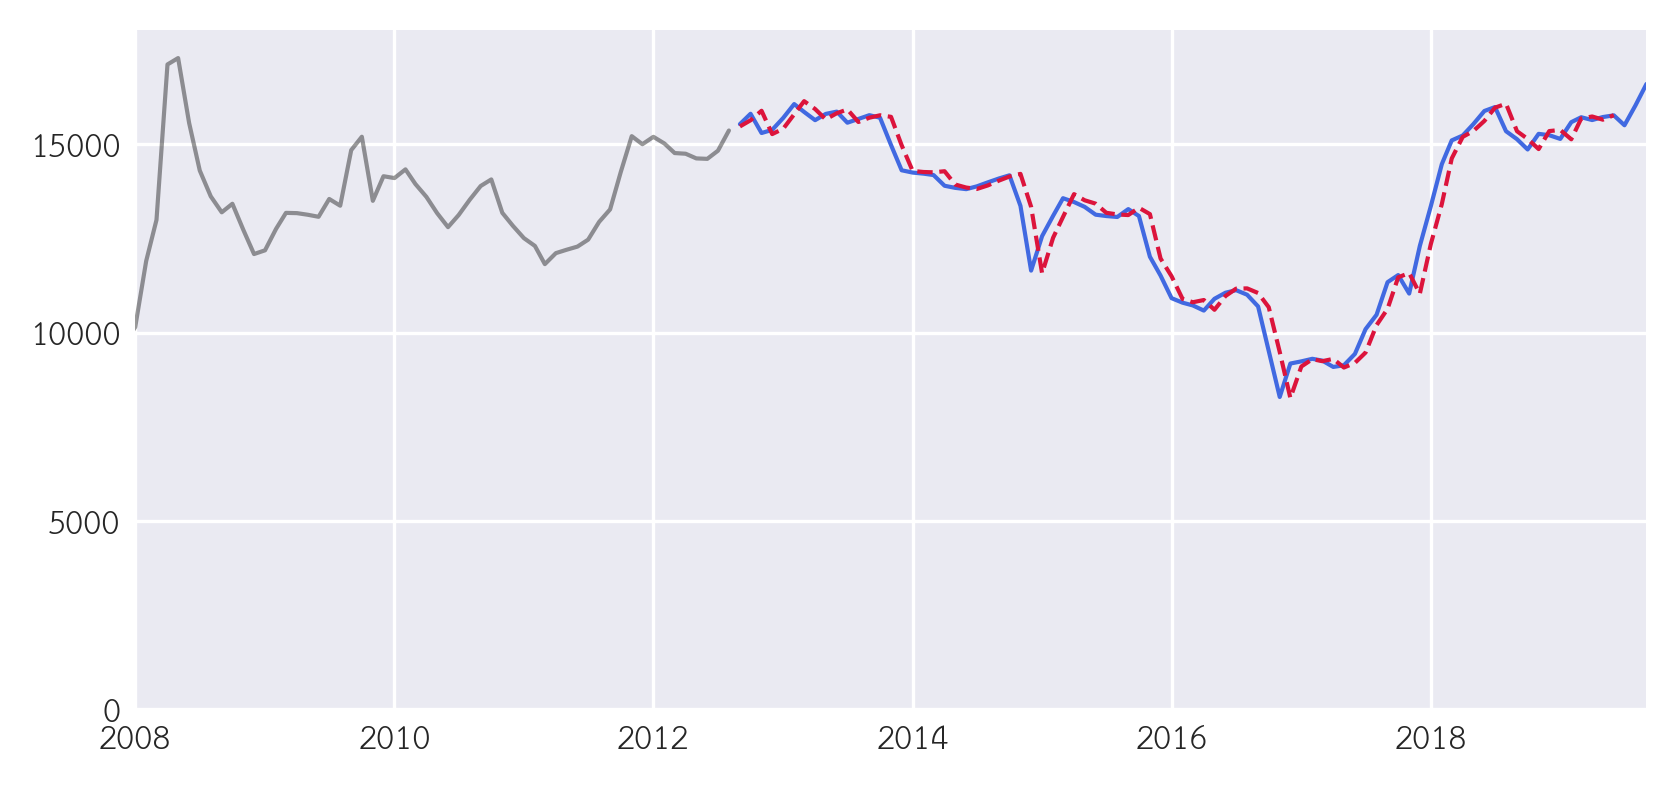

In [12]:
plot_fcast(hml, 'mlp', step=1)

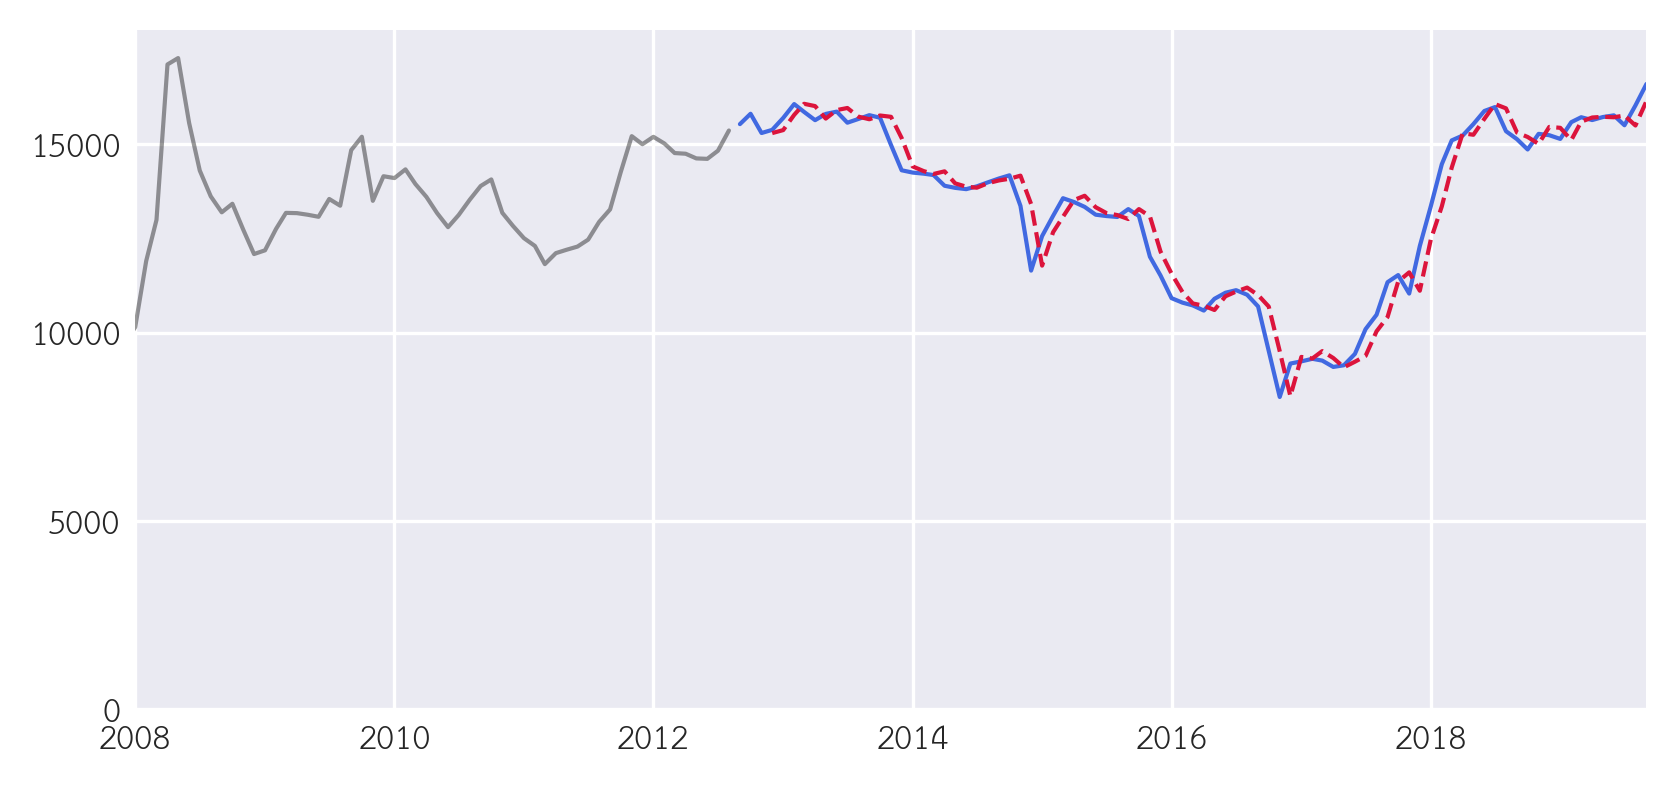

In [18]:
plot_fcast(hml, 'mlp', step=4)

In [15]:
model_measure(hml, hml.mlp_yhat, ['hml'])

,rmse,mae,mape
config,,,
hml,503.4071,348.8937,0.0284


In [14]:
model_measure(wht, wht.mlp_yhat, ['wht'])

,rmse,mae,mape
config,,,
wht,285.1482,217.2903,0.0270


In [13]:
model_measure(glu, glu.mlp_yhat, ['glu'])

,rmse,mae,mape
config,,,
glu,521.5118,374.8086,0.0343


In [ ]:
def mlp_fit(data, config, n_forecast=4, search_mode=False):
    
    # unpack config
    n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
    
    train, test = select_traintest(data, search_mode)
    
    # transform to kreas format
    x, y, date_idx = data_2keras(train, n_lag=n_lag, n_forecast=n_forecast)
    x = x.to_numpy()
    y = y.to_numpy()
    
    x_val, y_val, _ = data_2keras(test, n_lag=n_lag, n_forecast=n_forecast)
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    # define model
    if n_layers!=1:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    else:
        model = Sequential()
        model.add(Dense(n_nodes, activation='relu', input_dim=n_lag+1))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        
    # fit model
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0, validation_data=(x_val, y_val))
    return model

In [132]:
# mlp_configs[3]
config = (6, 1, 10, 200, 128, np.inf)
config

(6, 1, 10, 200, 128, inf)

In [133]:
npr.seed(1305)
history = mlp_fit(wht, config, search_mode=True)
res = history.history.history

In [122]:
val_mae = {}
val_mae[str(config)] = res['val_mae']

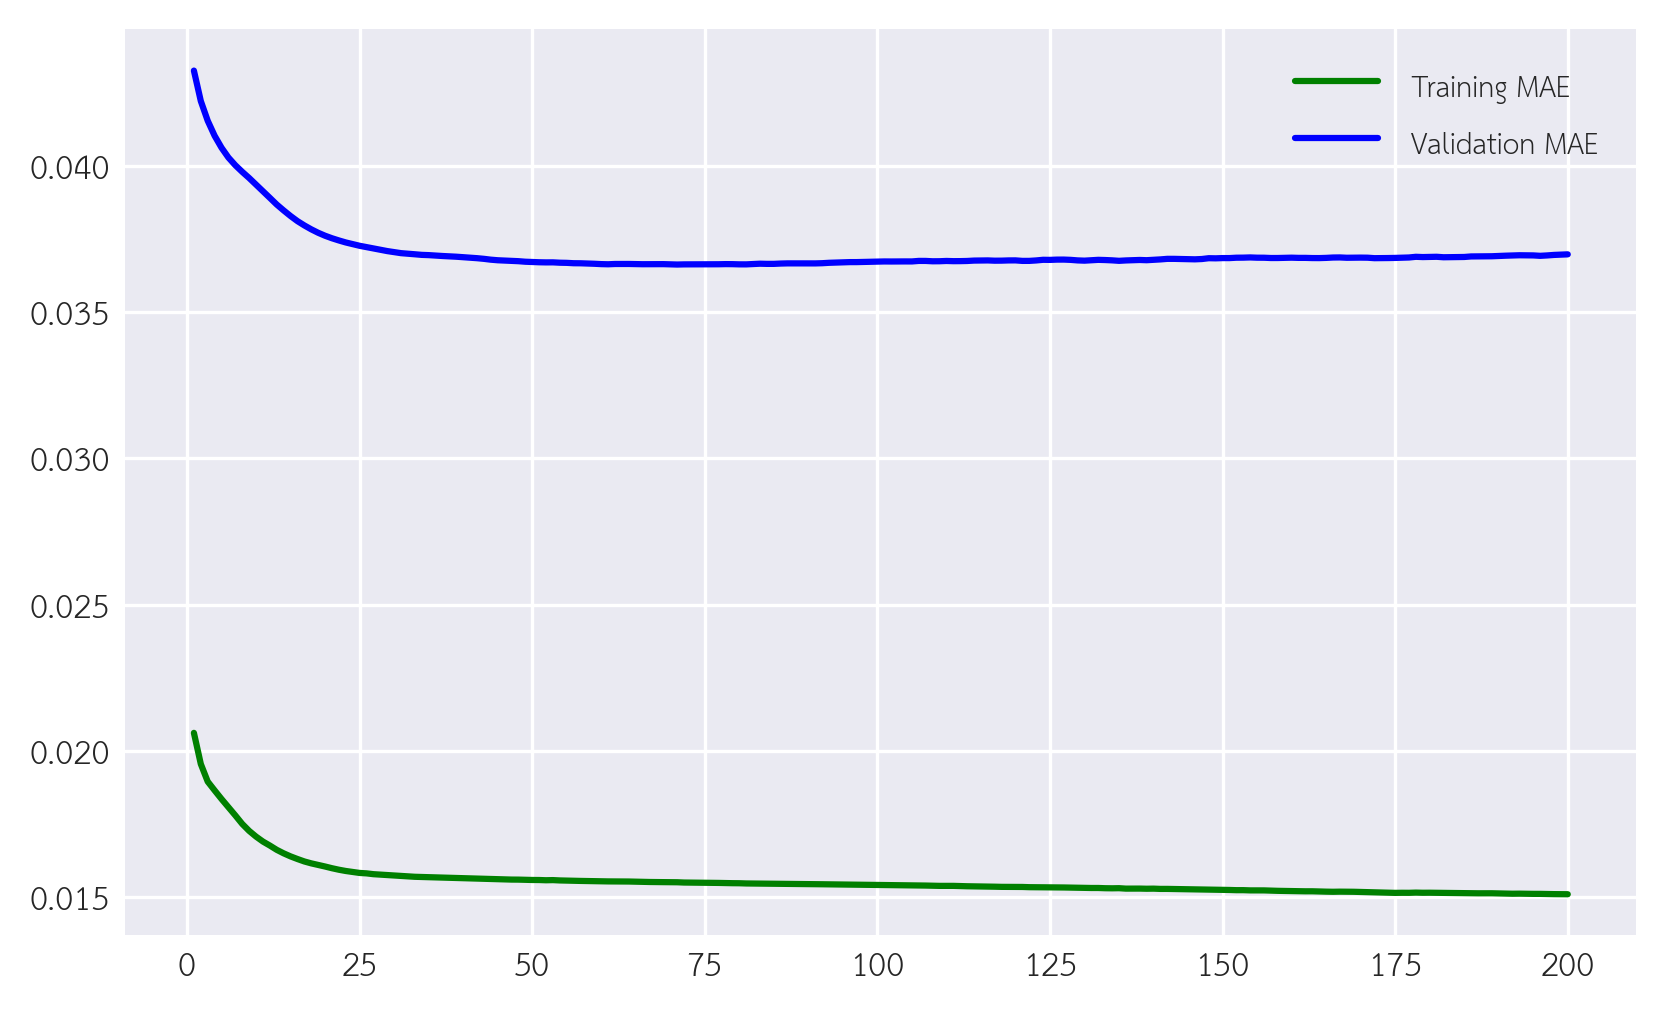

In [134]:
epochs = range(1, len(res['mae'])+1)

plt.plot(epochs, res['mae'], 'g', label='Training MAE')
plt.plot(epochs, res['val_mae'], 'b', label='Validation MAE')
plt.legend()